# Autofocus

In [1]:
from picamera2 import Picamera2
try:
    cam
except NameError:
    pass
else:
    cam.close()
cam = Picamera2()
cam.start(show_preview=True)
cam.set_controls({'AwbEnable':False,'AeEnable':False})
cam.set_controls({'ExposureTime':50000, 'AnalogueGain':3.0})

[0:22:46.704422018] [3176]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+27-7330f29b
[0:22:46.711861055] [3193]  INFO RPI pisp.cpp:695 libpisp version v1.0.7 28196ed6edcf 29-08-2024 (16:33:32)
[0:22:46.721324444] [3193]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@88000/imx219@10 to CFE device /dev/media1 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[0:22:46.724972703] [3176]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x480-XBGR8888 (1) 640x480-BGGR_PISP_COMP1
[0:22:46.725069018] [3193]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@88000/imx219@10 - Selected sensor format: 640x480-SBGGR10_1X10 - Selected CFE format: 640x480-PC1B


In [2]:
from enderscope import SerialUtils, Stage
# list available serial ports
ports = SerialUtils.serial_ports()
print (ports)

['/dev/ttyAMA10', '/dev/ttyACM0', '/dev/ttyUSB0']


In [3]:
lightport = ports[1]
stageport = ports[2]
s = Stage(stageport, 115200)
s.home()

In [4]:
import numpy as np
import cv2

# Entropic calculus function
def H(img):
   p,n = np.histogram(img,bins = np.arange(256))
   p = p / img.size
   ent=0
   for i in p:
       if i != 0 :
           ent = ent - i*np.log2(i)
   return ent

# Laplacian variance calculus function
def Var(img):
    laplacian = cv2.Laplacian(img, cv2.CV_32F)
    variance = laplacian.var()
    return variance

# Sobel gradient calculus function
def Sobel(img):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    variance = sobel.var()
    return variance

# Normalization function
def normalize_measure(measure, measure_min, measure_max):
    return (measure - measure_min) / (measure_max - measure_min)

# Combination of each function (Entropy, Variance of the Laplacian and the Sobel gradient)
def combined_score(img):
    entropy = H(img)
    variance_laplacian = Var(img)
    variance_sobel = Sobel(img)
    
    # Define maximum and minimum of each function to normalize them
    entropy_min = 0.0
    entropy_max = 8.0
    laplacian_min = 0.0
    laplacian_max = 1000.0
    sobel_min = 0.0
    sobel_max = 500.0
        
    norm_entropy = normalize_measure(entropy, entropy_min, entropy_max)
    norm_laplacian = normalize_measure(variance_laplacian, laplacian_min, laplacian_max)
    norm_sobel = normalize_measure(variance_sobel, sobel_min, sobel_max)

    score = (norm_entropy + norm_laplacian + norm_sobel) / 3
    return score

In [5]:
s.move_position([55,75,30])

In [6]:
zrange = np.array(range(-10,10,1))*1.5
zrange

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5])

In [ ]:
pos = s.get_position()
mxScore = -1
bestZ = 0
hs = []
vs = []
ss = []

for z in zrange:
    s.move_position([pos[0],pos[1],z+pos[2]])
    s.finish_moves()
    img = cam.capture_array("main")
    grayImage = (np.float32(img[:,:,0])+np.float32(img[:,:,1])+np.float32(img[:,:,2]))/3
    hs.append(H(img))
    vs.append(Var(img))
    ss.append(Sobel(img))
    score = combined_score(grayImage)
    if score>mxScore:
        mxScore = score
        bestZ = z

-10.5


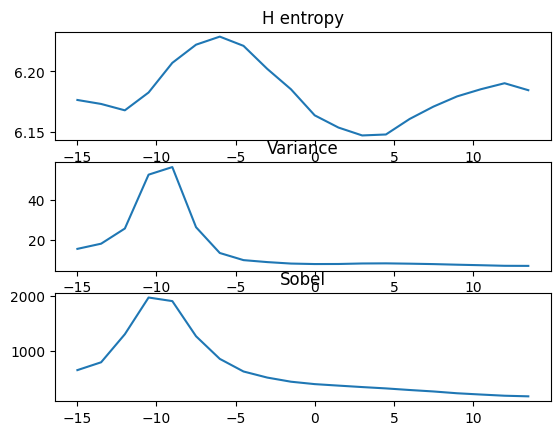

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3)
ax[0].plot(zrange,hs)
ax[0].set_title('H entropy')
ax[1].plot(zrange,vs)
ax[1].set_title('Variance')
ax[2].plot(zrange,ss)
ax[2].set_title('Sobel')
print (bestZ)


In [24]:
s.move_position([pos[0],pos[1],pos[2]+bestZ])

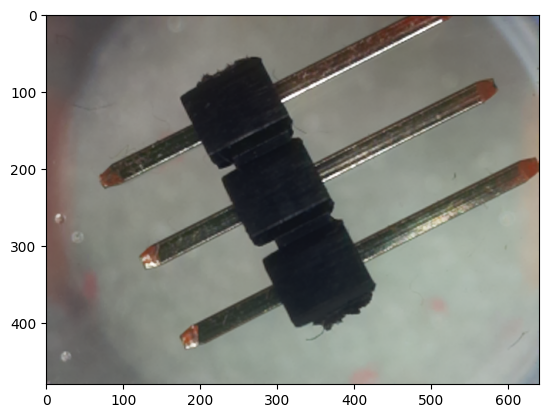

In [25]:
import matplotlib.pyplot as plt
img = cam.capture_array("main")
imgplot = plt.imshow(img)